In [26]:
import torch
import pandas as pd

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader


In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'PANNs'#'PANNs'#'YAMNet' #'VGGish'#'AI'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

0
RZUA01
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA01_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 2048])
1
RZUA02
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA02_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 2048])
2
RZUA04
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA04_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

In [6]:
x.shape

torch.Size([3, 92, 24, 2048])

## Edge Creation

In [7]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [8]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=11)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True


In [9]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

## Organizar de acá en adelante

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

class MatrixGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_dim):
        super(MatrixGCN, self).__init__()
        self.conv1d = torch.nn.Conv1d(1, 64, 24, stride=24)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, embedding_dim)

    def forward(self, x, edge_index):
        x = x.transpose(1,2).flatten(1)  # Flatten the matrix features
        x = self.conv1d(x.unsqueeze(1))
        x = x.view(x.size(0),-1)
        #print(x.shape)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model and optimizer
model = MatrixGCN(in_channels=64*2048, hidden_channels=2048, embedding_dim=8)#num_filters conv1d x num_original_features
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Unsupervised loss function (e.g., graph regularization)
def unsupervised_loss(embedding, edge_index):
    # This loss encourages connected nodes to have similar embeddings
    src, dst = edge_index
    distance = F.pairwise_distance(embedding[src], embedding[dst])
    return distance.mean()

# Training function
def train():
    model.train()
    model.double()
    for graph in train_loader:
        optimizer.zero_grad()
        embedding = model(graph.x.double(), graph.edge_index)
        loss = unsupervised_loss(embedding, graph.edge_index)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 12): #Oversmoothing?
    loss = train()
    if epoch % 3 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 003, Loss: 12.2791
Epoch: 006, Loss: 5.3068
Epoch: 009, Loss: 2.8486


In [11]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        embeddings = model(graph.x.double(), graph.edge_index)

# Function to perform clustering and evaluate
def cluster_and_evaluate(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(embeddings.numpy())
    silhouette_avg = silhouette_score(embeddings.numpy(), clusters)
    return clusters, silhouette_avg

# Try different numbers of clusters
best_n_clusters = 0
best_silhouette = -1
for n_clusters in range(2, 10):  # Try 2 to 10 clusters
    clusters, silhouette_avg = cluster_and_evaluate(embeddings, n_clusters)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg}")
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters

print(f"\nBest number of clusters: {best_n_clusters}")

# Perform final clustering with the best number of clusters
final_clusters, _ = cluster_and_evaluate(embeddings, best_n_clusters)

print("\nFinal Clustering Results:")
for i in range(best_n_clusters):
    print(f"Cluster {i}: {(final_clusters == i).sum()} nodes")

# Example: Find similar nodes
def find_similar_nodes(node_idx, top_k=5):
    node_embedding = embeddings[node_idx].unsqueeze(0)
    distances = F.cosine_similarity(node_embedding, embeddings)
    top_similar = torch.topk(distances, k=top_k+1)
    return top_similar.indices[1:].tolist()  # Exclude the node itself

# Find similar nodes for the first node
similar_nodes = find_similar_nodes(0)
print(f"\nNodes similar to node 0: {similar_nodes}")

For n_clusters = 2, the average silhouette score is : 0.54735877741215
For n_clusters = 3, the average silhouette score is : 0.4780444958099121
For n_clusters = 4, the average silhouette score is : 0.4442926845992026
For n_clusters = 5, the average silhouette score is : 0.3645757556442464
For n_clusters = 6, the average silhouette score is : 0.37126008020806345
For n_clusters = 7, the average silhouette score is : 0.3688452762918218
For n_clusters = 8, the average silhouette score is : 0.3899669257234765
For n_clusters = 9, the average silhouette score is : 0.42683999873638573

Best number of clusters: 2

Final Clustering Results:
Cluster 0: 40 nodes
Cluster 1: 52 nodes

Nodes similar to node 0: [0, 33, 1, 21, 43]


In [12]:
graph

DataBatch(x=[92, 24, 2048], edge_index=[2, 1260], batch=[92], ptr=[2])

In [13]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 8])


In [14]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

In [15]:
import colorsys
import plotly.graph_objs as go


# Sample data
locations = df_map.reset_index().rename(columns={'index': 'name'}).to_dict('records')

def generate_colors(n):
    HSV_tuples = [(x * 1.0 / n, 0.7, 0.7) for x in range(n)]
    return list(map(lambda x: f'rgb{tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x))}', HSV_tuples))


# color_map = {0: 'red', 1: 'blue', 2:'green'}
unique_labels = list(set(final_clusters))
colors = generate_colors(len(unique_labels))
color_map = dict(zip(unique_labels, colors))

# Create traces
traces = []
for location, label in zip(locations, final_clusters):
    traces.append(
        go.Scattermapbox(
            lat=[location['latitude_IG']],
            lon=[location['longitud_IG']],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=14,
                color=color_map[label],
                opacity=0.8
            ),
            text=[f"{location['field_numb']} ({label})"],
            name=location['field_numb'],
            showlegend=True
        )
    )

# Create layout
layout = go.Layout(
    mapbox=dict(
        style="open-street-map",
        # center=dict(lat=39, lon=-98),  # Center of the US
        center=dict(lat=df_map.mean().values[0], lon=df_map.mean().values[1]),
        zoom=11.7
    ),
    showlegend=True
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

## Matriz de similitud

In [16]:
embs = embeddings.numpy()
sim_mat = (embs@embs.T)
sim_mat

array([[3.22445312, 3.5609267 , 2.71391168, ..., 2.97875651, 1.72600245,
        2.77566805],
       [3.5609267 , 3.99295825, 3.03812945, ..., 3.34548632, 1.75515888,
        3.08832168],
       [2.71391168, 3.03812945, 2.56311904, ..., 2.78313828, 1.61855988,
        2.59136602],
       ...,
       [2.97875651, 3.34548632, 2.78313828, ..., 3.11756265, 1.80791193,
        2.82182753],
       [1.72600245, 1.75515888, 1.61855988, ..., 1.80791193, 1.69948686,
        1.69226622],
       [2.77566805, 3.08832168, 2.59136602, ..., 2.82182753, 1.69226622,
        2.6326558 ]])

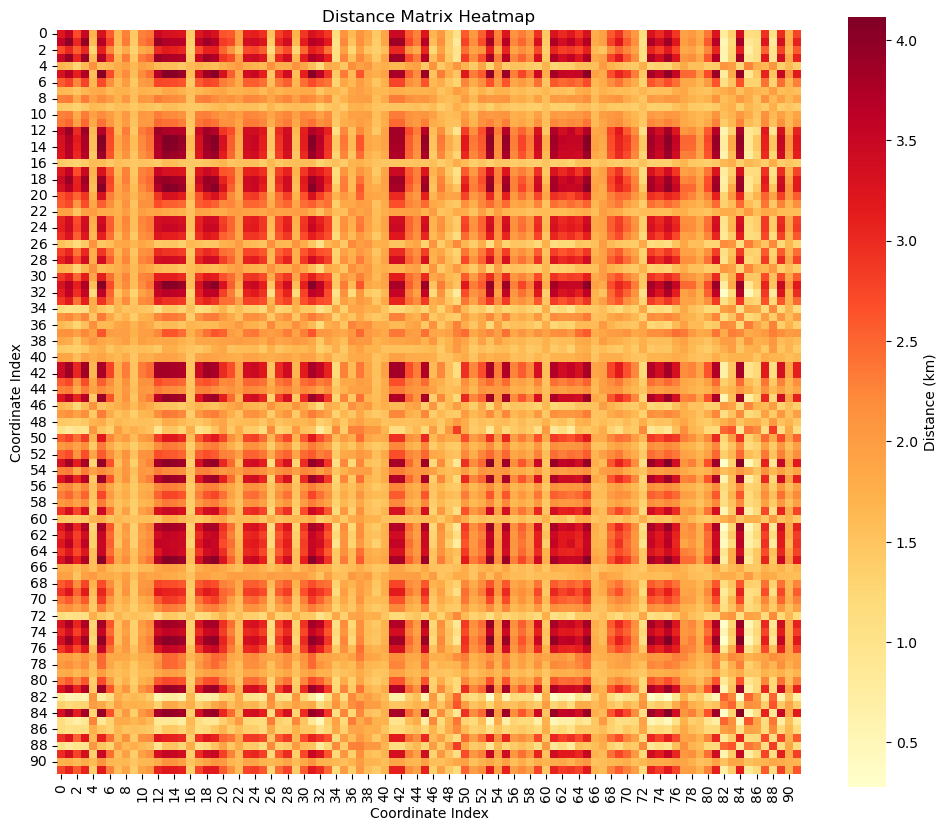

In [17]:
plot_distance_matrix_heatmap(sim_mat)

In [18]:
# density metric:

print(np.mean(sim_mat)) #axis = 0: por nodos

2.1401667747907456


In [19]:
# connectivity metric (only if thresholded):

print(np.count_nonzero(sim_mat))

8464


In [20]:
# total weight (es density sin promediar)

print(np.sum(sim_mat))

18114.37158182887


In [21]:
def floyd_warshall(matrix):
    """Implement Floyd-Warshall algorithm for all-pairs shortest paths"""
    n = len(matrix)
    dist = np.array(matrix, dtype=float)
    
    # Replace inf with large number for calculations
    dist[dist == float('inf')] = 1e9
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    
    return dist

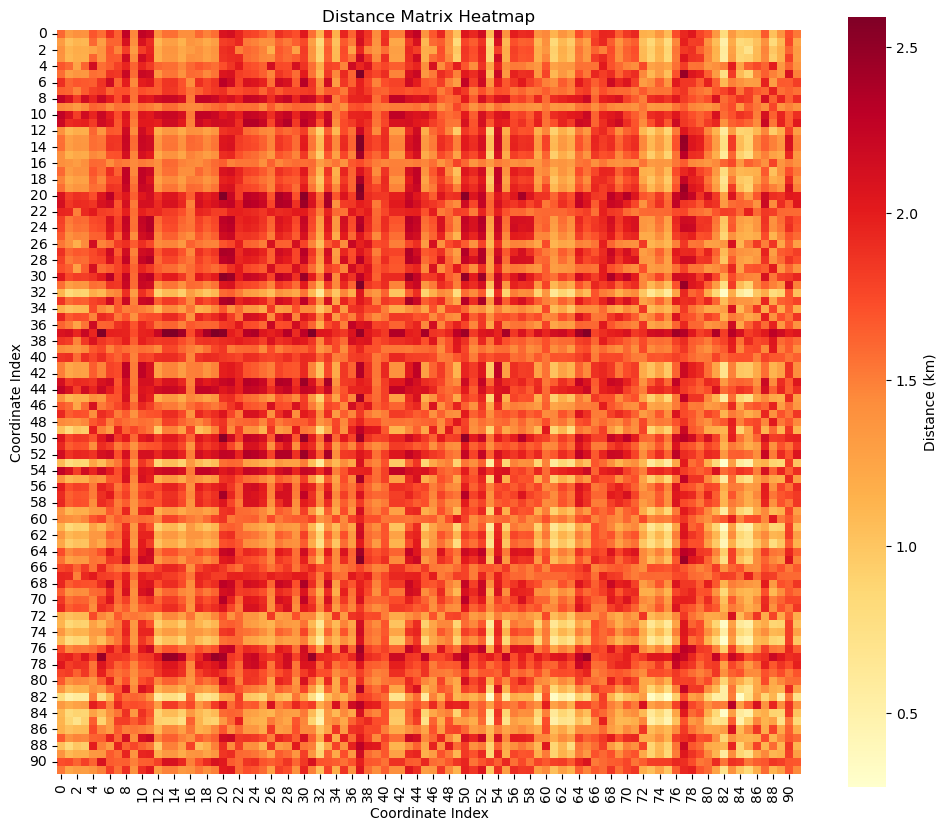

In [22]:
dist_matrix = floyd_warshall(sim_mat)
plot_distance_matrix_heatmap(dist_matrix)

In [23]:
# diameter
print(np.max(dist_matrix))

2.589363664634618


In [24]:
#average path
print(np.mean(dist_matrix))

1.6309937312988483


In [25]:
#Betweeness centrality

n = len(dist_matrix)
centrality = np.zeros(n)
for s in range(n):
    for t in range(n):
        if s != t:
            # Count shortest paths going through each vertex
            for v in range(n):
                if v != s and v != t:
                    if dist_matrix[s][t] == dist_matrix[s][v] + dist_matrix[v][t]:
                        centrality[v] += 1
value = np.mean(centrality)
print(value)

36.34782608695652
